# Multi Layer Perceptron
This notebook will build and train a multilayer perceptron (MLP) from scratch with minimal reliance upon libraries. The MLP will be trained on the popular iris dataset. 

### Load Libraries and Split Data
The data used will be split using an 80/20 ratio of training to testing data.

In [390]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import pandas as pd

np.random.seed(0xdeadbeef)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [391]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris(as_frame=True)
data.frame.head()

# Perform 80/20 split for test and train
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=0xdeadbeef)
print(x_train.head())
print(data.target_names)

    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
47                4.6               3.2                1.4               0.2
30                4.8               3.1                1.6               0.2
40                5.0               3.5                1.3               0.3
79                5.7               2.6                3.5               1.0
64                5.6               2.9                3.6               1.3
['setosa' 'versicolor' 'virginica']


### Activation Functions
As part of this journal I will investigate a series of activation functions that could be acceptable choices for an MLP implementation. I will investigate and assess the hyperbolic tan function, sigmoid function, and leaky ReLU function.

In [392]:
def activate_hyperbolic(x):
    '''
    Hyperbolic tangent activation function
    Args:
     - x: input tensor
    Returns:
     - activated tensor
    '''
    return tf.tanh(x)

def activate_sigmoid(x):
    return 1 / (1. + np.exp(-x) + tf.keras.backend.epsilon())

def activate_lrelu(x, leak_factor=0.01):
    return tf.maximum(x, leak_factor * x)

def lrelu_derivative(x, leak_factor=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = leak_factor
    return dx

def sigmoid_derivative(x):
    return x * (1 - x)

def hyperbolic_derivative(x):
    return 1 - tf.square(tf.tanh(x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

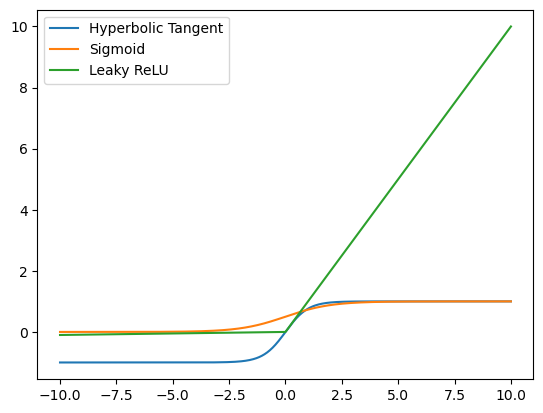

In [393]:
test_data = np.linspace(-10, 10, 1000)

# Plot the activation functions
import matplotlib.pyplot as plt

plt.plot(test_data, activate_hyperbolic(test_data), label='Hyperbolic Tangent')
plt.plot(test_data, activate_sigmoid(test_data), label='Sigmoid')
plt.plot(test_data, activate_lrelu(test_data), label='Leaky ReLU')
plt.legend()

In [394]:
def mean_squared_error(y_pred, y_true):
    squared_errors = [(true - pred) ** 2 for true, pred in zip(y_true, y_pred)]
    return np.mean(squared_errors)

In [395]:
import time

class MultiLayerPerceptron():
    def __init__(self, activation_func=activate_hyperbolic, derivative_func=hyperbolic_derivative, loss_func=mean_squared_error):
        self.activation_func = activation_func
        self.derivative_func = derivative_func
        self.loss_func = loss_func

        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': []
        }

    def build(self, input_shape, hidden_config = np.array([5, 5, 5]), num_classes=3, batch_size=8):
        '''
        Builds the model. This must be run before fit() or predict()
        Args:
         - input_size: size of input layer (number of features)
         - hidden_config: list containing number of neurons in each hidden layer
         - output_size: size of output layer
         - batch_size: size of batches used for training
        '''
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.hidden_config = hidden_config
        self.batch_size = batch_size

        self.layer_sizes = np.array([input_shape[1]] + [neuron for neuron in hidden_config] + [num_classes])
        print(self.layer_sizes)
        
        self.__blank_layers()
        self.weights = []
        for i in range(self.layer_sizes.shape[0]-1):
            layer_weight = np.random.uniform(-1, 1, size=[self.layer_sizes[i], self.layer_sizes[i+1]])
            self.weights.append(layer_weight)

        # self.weights = self.weights

    def __blank_layers(self):
        self.layers = [np.empty((self.batch_size, neurons)) for neurons in self.layer_sizes] # Create empty weights matrix

    def __forward_feed(self, batch):
        '''
        Performs forward feed on a batch of data
        Args:
         - batch: batch of data to feed forward
        Returns:
         - output of forward feed
        '''
        # Initialize input layer
        hl = batch
        self.layers[0] = hl

        # Perform forward feed
        for i,weight in enumerate(self.weights):
            hl = self.activation_func(np.dot(hl, weight)) # Perform activation function on linear combination (i.e. dot product) of previous layer and weights
            self.layers[i+1] = hl

        return softmax(np.array(self.layers[-1])) # Final activation of output layer

    def __back_propagate(self, x, y, lr=0.01, penalty = 0.01):
        '''
        Performs back propagation over the network
        Args:
            - x: input data
            - y: true labels
            - lr: learning rate
            - peanlty: L1 regularization penalty
        Result: None
        '''
        delta = (x - y) * self.derivative_func(self.layers[-1]) # Calculates delta for output layer
        for i in range(1, len(self.weights)+1): # Loops through weights
            weight_gradients = np.dot(np.array(self.layers[-i-1]).T, delta) / self.batch_size # Calculates weight gradient for layer prior to current layer (to the left of)
            
            l1_regu = penalty * np.sign(self.weights[-i]) # L1 regularization
            weight_gradients += l1_regu # Add regularization to weight gradients

            self.weights[-i] -= lr * weight_gradients # Update weights using negative weight gradients adjusting for learning rate
            delta = self.derivative_func(self.layers[-i-1]) * np.dot(delta, np.array(self.weights[-i]).T) # Calculate delta for current layer


    def __convert_probs_to_categorical(self, x):
        cats = np.zeros((x.shape[0], self.num_classes)) # Setup array shape
        cats[np.arange(x.shape[0]), x.argmax(axis=1)] = 1 # Set the index with the highest probability to one (i.e. categorical representation)
        return cats

    def __loss(self, y_pred, y_true):
        return self.loss_func(y_pred=y_pred, y_true=y_true)

    def __accuracy(self, y_pred, y_true):
        return tf.keras.backend.mean(tf.keras.backend.equal(tf.keras.backend.argmax(y_pred, axis=1), tf.keras.backend.argmax(y_true, axis=1))) # This may not work...

    def fit(self, x_train, y_train, x_test, y_test, epochs=100, learning_rate=0.01, patience=10):

        entries = x_train.shape[0]

        best_val_loss = float('inf')
        current_patience = 0

        for epoch in range(epochs):
            # start_timestamp = time.time()
            self.__blank_layers() # Reset layers


            shuffle = np.random.permutation(entries)
            x_batches = np.array_split(x_train[shuffle], entries / self.batch_size)
            y_batches = np.array_split(y_train[shuffle], entries / self.batch_size)

            loss = 0
            acc = 0

            for x,y in zip(x_batches, y_batches):
                out = self.__forward_feed(x)

                loss += self.__loss(out, y)
                acc += self.__accuracy(self.__convert_probs_to_categorical(out), y)
                self.__back_propagate(out, y, learning_rate)
            
            loss /= len(x_batches)
            acc /= len(x_batches)

            self.history['loss'].append(loss)
            self.history['accuracy'].append(acc)

            self.__blank_layers()

            out = self.__forward_feed(x_test)
            

            val_loss = self.__loss(out, y_test)
            val_acc = self.__accuracy(self.__convert_probs_to_categorical(out), y_test)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_acc)

            if(val_loss < best_val_loss):
                best_val_loss = val_loss
                current_patience = 0
            else:
                current_patience += 1
            
            if patience is not None:
                if current_patience >= patience:
                    print(f"Early stop at epoch {epoch}. Validation loss has not improved for {patience} epochs.")
                    break

            # print(f"Epoch {epoch}")

    def predict(self, x):
        self.__blank_layers()
        out = self.__forward_feed(x)
        return self.__convert_probs_to_categorical(out)
    
    def save_weights(self, path):
        np.save(path, self.weights)


[5 6 6 3]
Early stop at epoch 60. Validation loss has not improved for 10 epochs.


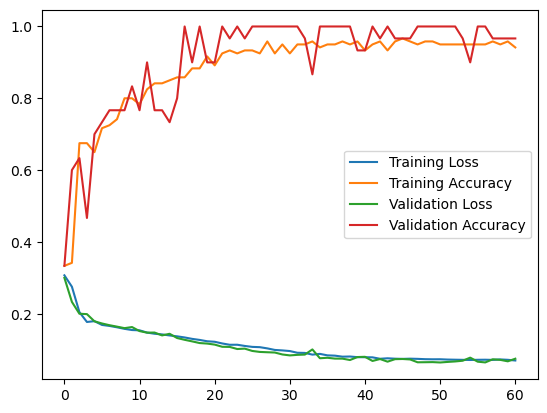

In [396]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(tf.one_hot(y_train, depth=3))
y_test = np.array(tf.one_hot(y_test, depth=3))

x_train = np.concatenate((x_train, np.ones((x_train.shape[0], 1))), axis=1) # Add bias
x_test = np.concatenate((x_test, np.ones((x_test.shape[0], 1))), axis=1) # Add bias

mlp = MultiLayerPerceptron(loss_func=mean_squared_error, activation_func=activate_hyperbolic, derivative_func=hyperbolic_derivative)

mlp.build(input_shape=x_train.shape, batch_size=8, hidden_config=[6]*2)
mlp.fit(x_train, y_train, x_test, y_test, epochs=100, learning_rate=0.01)

plt.plot(mlp.history['loss'], label='Training Loss')
plt.plot(mlp.history['accuracy'], label='Training Accuracy')
plt.plot(mlp.history['val_loss'], label='Validation Loss')
plt.plot(mlp.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [397]:
out = mlp.predict([x_test[6]])

print(out)
print(y_test[6])


[[0. 0. 1.]]
[0. 0. 1.]
